# NiN网络中的网络

### 想法
- LeNet、AlexNet和VGG都有一个共同的设计模式：
  - 通过一系列的卷积层和池化层来提取空间结构特征
  - 然后通过全连接层对特征的表征进行处理
- 如果使用了全连接层，可能会完全放弃表征的空间结构
- NiN提供了一个非常简单的解决方案：
  - **在每个像素的通道上分别使用多层感知机**（在每个像素位置应用一个全连接层）

### 全连接层的问题
- 卷积层需要较少的参数$c_i \times c_o \times k^2$
- 但卷积层后的第一个全连接层的参数
  - LeNet $16\times5\times5\times120=48K$
  - AlexNet $256\times5\times5\times4096=26M$
  - VGG $512\times7\times7\times4096=102M$

### NiN块
- 一个卷积层后跟两个全连接层（$1\times1$的卷积层）
  - $1\times1$的卷积层等价于全连接层
  - 步幅1，无填充，输出形状和卷积层输出一样
  - 起到全连接层的作用

### NiN架构
- 无全连接层
- 交替使用NiN块和步幅为2的最大池化层
  - 逐步减小高宽和增大通道数
- 最后使用全局平均池化层得到输出
  - 其输入通道数是类别数

### NiN Networks
- 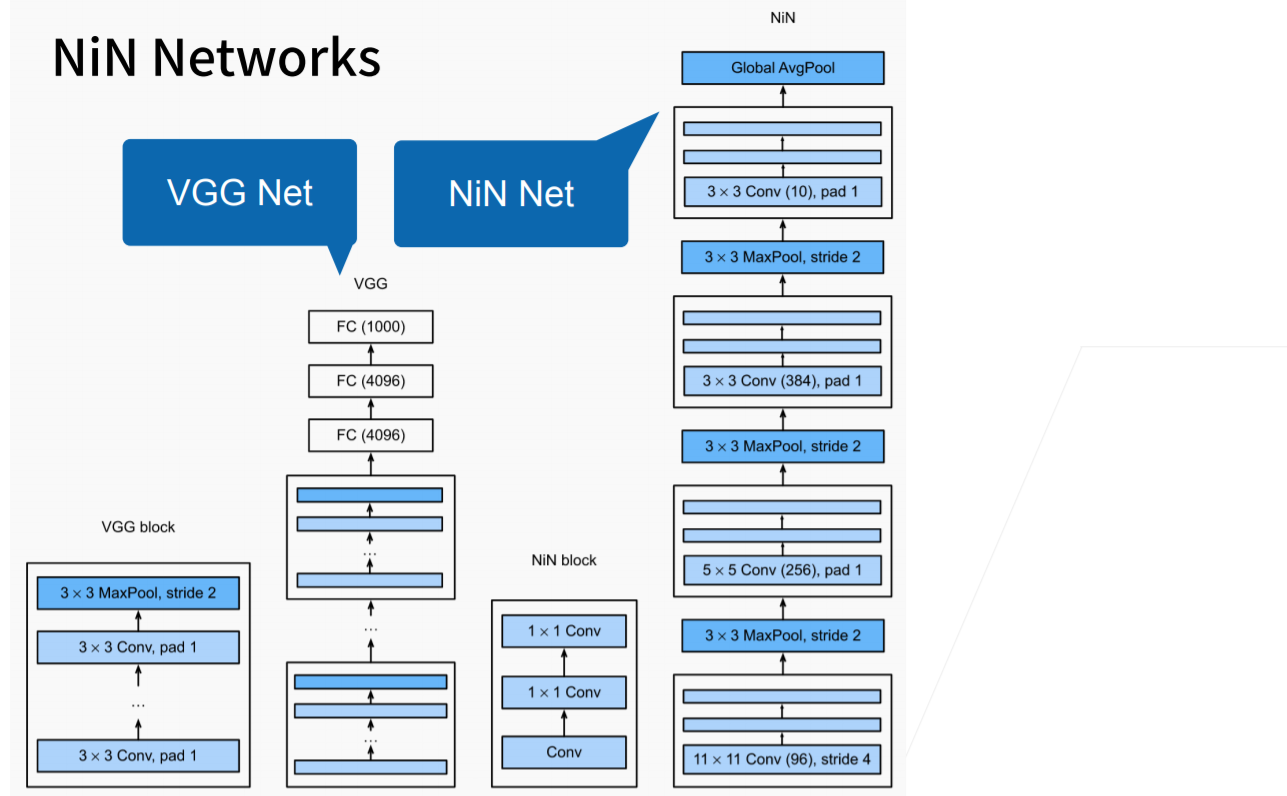



### 总结
- NiN块使用卷积层加两个$1\times1$的卷积层
  - 后者对每个像素增加了非线性行
- NiN使用全局平均池化层（即在所有位置上进行求和）来替代VGG和AlexNet中的全连接层
  - 该池化层通道数量为所需的**输出数量**（本身是不会改变通道数的，下面有更详细讲解，需要再前一步进行改变通道数维类别数）
  - 不容易过拟合，更少的参数个数

In [ ]:
!pip install d2l

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1),
      nn.ReLU()
  )

#### **全局平均汇聚层Global Average Pooling**
- 常用于卷积神经网络中最后几层，尤其是分类任务，*帮助模型输出每个类别的预测*
- 对每个通道进行空间上的平均汇聚，最终将**每个通道上**的所有元素平均为一个值
- 输入是$(N, C, H, W)$即批次大小、通道数、高宽，则输出为**$(N, C, 1, 1)$**

In [ ]:
net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

In [ ]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
  X = layer(X)
  print(layer.__class__.__name__, 'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.377, train acc 0.860, test acc 0.859
1023.8 examples/sec on cuda:0


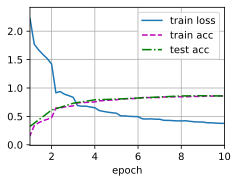

In [ ]:
lr , num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

### 注意：
- softmax写在loss中的
- 使用全局平均池化层，模型复杂度降低，提升泛化性，但收敛变慢（这个基本无所谓）
- pytorch构建的net是自动初始化，这是手动初始化
- **预测**怎么做（3.6节的预测函数，X到GPU，pred到CPU）


### 练习
1. 调整NiN的超参数，以提高分类准确性
- 使用96形状的
- 没有全连接层，就不用计算全连接层需要多大的输入了

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

def nin_block(in_channels, out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1),
      nn.ReLU()
  )

net = nn.Sequential(
    nin_block(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    nin_block(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

hyper_0 = [0.06, 10, 128]
hyper_1 = [0.04, 10, 128]
hyper_2 = [0.05, 10, 64]
hyper_3 = [0.05, 10, 512]
hyper_4 = [0.01, 10, 128]
hyper_param = [hyper_0, hyper_1, hyper_2, hyper_3, hyper_4]


def evaluate_accuracy_gpu(net, data_iter, device=None):
  if isinstance(net, nn.Module):
    net.eval()
    if not device:
      device = next(iter(net.parameters())).device
  metric = d2l.Accumulator(2)
  for X, y in data_iter:
    if isinstance(X, list):
      X = [x.to(device) for x in X]
    else:
      X = X.to(device)
    y = y.to(device)
    metric.add(d2l.accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
  def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
      nn.init.xavier_uniform_(m.weight)
  net.apply(init_weights)

  net.to(device)

  optimizer = torch.optim.SGD(net.parameters(), lr=lr)
  loss = nn.CrossEntropyLoss()
  timer, num_batches = d2l.Timer(), len(train_iter)

  for epoch in range(num_epochs):
    timer.start()
    metric = d2l.Accumulator(3)
    net.train()
    for i, (X, y) in enumerate(train_iter):
      optimizer.zero_grad()
      X, y = X.to(device), y.to(device)
      l = loss(net(X), y)
      l.backward()
      optimizer.step()
      with torch.no_grad():
        metric.add(l * X.shape[0], d2l.accuracy(net(X), y), X.shape[0])
      timer.stop()
      train_l = metric[0] / metric[2]
      train_acc = metric[1] / metric[2]
    test_acc = evaluate_accuracy_gpu(net, test_iter)
  return [train_l, train_acc, test_acc]

for hyper in hyper_param:
  lr, num_epochs, batch_size = hyper
  train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
  res = train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
  print(f'lr:{lr}, num_epochs:{num_epochs},batch_size:{batch_size}, \n\t loss {res[0]:.3f}, train acc {res[1]:.3f},test acc {res[2]:.3f}')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


lr:0.06, num_epochs:10,batch_size:128, 
	 loss 0.373, train acc 0.898,test acc 0.867
lr:0.04, num_epochs:10,batch_size:128, 
	 loss 0.418, train acc 0.876,test acc 0.836
lr:0.05, num_epochs:10,batch_size:64, 
	 loss 1.219, train acc 0.584,test acc 0.612
lr:0.05, num_epochs:10,batch_size:512, 
	 loss 0.941, train acc 0.715,test acc 0.680
lr:0.01, num_epochs:10,batch_size:128, 
	 loss 1.093, train acc 0.620,test acc 0.611


2. 为什么NiN块中有两个$1\times1$卷积层？删除一个，观察其结果
- $1\times1$卷积层在NiN模型中起到了重要作用，可以增加网络的非线性能力，同时保持感受野大小不变
- 删除一个会影响模型精度

loss 0.345, train acc 0.874, test acc 0.855
1409.0 examples/sec on cuda:0


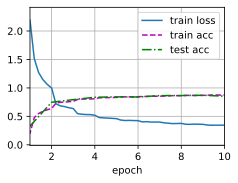

In [ ]:
def nin_block_1(in_channels, out_channels, kernel_size, strides, padding):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
      nn.ReLU(),
      nn.Conv2d(out_channels, out_channels, kernel_size=1),
      nn.ReLU()
  )

net = nn.Sequential(
    nin_block_1(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(3, stride=2),
    nin_block_1(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(3, stride=2),
    nin_block_1(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(3, stride=2),
    nn.Dropout(0.5),
    nin_block_1(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

# 预测 不知道是否正确？ 先用一个简单的模型试一下

In [ ]:
def predict_ch6(net, test_iter, device=d2l.try_gpu()):
  net.eval()
  for X, y in test_iter:
    X, y = X.to(device), y.to(device)
    break
  with torch.no_grad():
    trues = net(X)
  trues = trues.cpu()
  return torch.argmax(trues, dim=1)

predict_ch6(net, test_iter, d2l.try_gpu())

3. NiN的资源使用情况
- 参数的数量
  - 参数量计算方法：$kernel \times kernel \times channel_{input} \times channel_{output}$
- 计算量
  - 计算量计算方法：$kernel \times kernel \times channel_{input} \times channel_{output} \times map \times map$
- 训练期间需要多少显存
  - 显存里包含的内容：参数的权重，参数的梯度，以及梯度反向传播过程中的中间值，还有数据


4. 一次性直接将$384 \times 5 \times 5$的表示缩减为$10 \times 5 \times 5$的表示，会存在哪些问题？
- 在最后一层的行为，可能会导致信息丢失